# Libraries

In [485]:
# import libraries

import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split, KFold

# Functions

In [486]:
# unpickle the files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [487]:
# load all CIFAR
def load_CIFAR10():

    train_images = np.zeros((50000, 32, 32, 3), dtype=np.uint8)
    train_labels = np.zeros((50000,), dtype=np.uint8)
    
    # get training data
    for i in range(5):
        train_dict = unpickle(f'./data/cifar-10-batches-py/data_batch_{i+1}')
        train_images[i*10000:(i+1)*10000] = train_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        train_labels[i*10000:(i+1)*10000] = train_dict[b'labels']

    # get testing data
    test_dict = unpickle('./data/cifar-10-batches-py/test_batch')
    test_images = test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    val_labels = np.array(test_dict[b'labels'])

    # convert from integers to floats
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')

    # scale image pixels to [0, 1]
    train_images, test_images = train_images / 255.0, test_images / 255.0

    # one hot encode target labels
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)

    return ((train_images, train_labels), (test_images, val_labels))

In [488]:
def load_MNIST():

    return

In [489]:
def load_Cho():
    # import cho dataset
    cols = ['Gene_ID', 'Ground_Truth_Cluster_ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']
    df_cho = pd.read_csv('./data/cho.txt', sep="	", names=cols, header=None)

    return df_cho

In [490]:
def validation_CIFAR(images, labels):
    images, images_val, labels, labels_val = train_test_split(images, labels, test_size=0.1)

    print(f"New training/labels length: {len(images)}/{len(labels)}")
    print(f"New validation/labels length: {len(images_val)}/{len(labels_val)}")
    
    return ((images, labels), (images_val, labels_val))

In [491]:
#debug
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(df_cho):
    train_data = df_cho.iloc[train_index].values

In [492]:
#debug 
print(train_data.shape[1])

18


In [493]:
def validation_Cho(df):
    kf = KFold(n_splits=10, shuffle=True)

    for train_index, test_index in kf.split(df):
        train_data = df.iloc[train_index].values
        train_labels = df.iloc[train_index]
        val_data = df.iloc[test_index].values
        val_labels = df.iloc[test_index]

    # reshape data for CNN
    train_data = np.reshape(train_data, (train_data.shape[0], 3, 6, 1))
    val_data = np.reshape(val_data, (val_data.shape[0], 3, 6, 1))

    # extract labels
    train_labels = train_labels.iloc[:, 1].values
    val_labels = val_labels.iloc[:, 1].values

    # one hot encode target labels
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)

    print(f"New training/labels length: {len(train_data)}/{len(train_labels)}")
    print(f"New validation/labels length: {len(val_data)}/{len(val_labels)}")
    
    return (train_data, train_labels), (val_data, val_labels)

In [494]:
# (shape of the data, and the number of labels)
def build_model_CNN(shape, labels_size):
   
    # define cnn model
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(labels_size, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # show summary 
    model.summary()
    return model

In [495]:
def verify_CIFAR(data, labels):

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # show img
        plt.imshow(data[i], cmap=plt.cm.binary)
        
        # show label
        index = np.argmax(labels[i]).astype(int) # needed after one-hot encoding
        plt.xlabel(class_names[index])
        
    plt.show()

In [496]:
# plot diagnostic learning curves (History object, string data name, and string indicating validaiton or test set)
# graph showing loss & accuracy over the number of epochs
def show_diagnostics(history, dataset_name, val_or_test):

    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label=val_or_test)
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label=val_or_test)
    
    # adjust visuals
    plt.suptitle('CNN - ' + dataset_name)
    plt.subplots_adjust(hspace=0.5)
    plt.legend()

    # save plot to file
    plt.show()
    #filename = os.getcwd()
    #plt.savefig(filename + '_' + dataset_name + '_evaluation.png')
    plt.close()

In [497]:
def prediction(model, test):
    # assuming your model is called 'model'
    pred = model.predict(test)

    # get the index of the class with the highest probability
    label = np.argmax(pred)

    # print result
    print(label)

# Run on CIFAR-10

In [498]:
def run_CIFAR10():
    (train_data, train_labels), (test_data, test_labels) = load_CIFAR10()

    print("\nVerifying Data...")

    verify_CIFAR(train_data, train_labels)

    print("Data Verified!\n")
    print("------------------------------------------------------------------")
    print("Creating Validation Set...")

    (train_data, train_labels), (validation_data, validation_labels) = validation_CIFAR(train_data, train_labels)

    print("Validation Set Created!\n")
    print("------------------------------------------------------------------")
    print("Building Model...")

    model_CIFAR = build_model_CNN((3, 3), (32, 32, 3), 10)

    print("Model Built!\n")
    print("------------------------------------------------------------------")
    print("Fitting Model...")

    history_CIFAR10 = model_CIFAR.fit(train_data, train_labels, epochs=2, batch_size=64, validation_data=(validation_data, validation_labels), verbose=0)

    print("Model Fitted!\n")

    # show learning curves
    show_diagnostics(history_CIFAR10, "CIFAR-10", "validation")
    # debug
    print(history_CIFAR10)
    print(history_CIFAR10.history['accuracy'])

    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # evaluate model
    test_loss, test_acc = model_CIFAR.evaluate(test_data,  test_labels)
    print("Loss: ", test_loss)
    print(f"Accuracy: {test_acc :.2%}") # 45.07%

    print("\nRun Complete!\n")
    return

# run_CIFAR10()

# Run on MNIST

In [499]:
def run_MNIST():
    # load dataset
    # = load_MNIST()

    print("\nVerifying Data...")

    verify_data(train_data, train_labels)

    print("Data Verified!\n")
    print("------------------------------------------------------------------")
    print("Applying 10-fold cross-validation...")

    verify_data(train_data, train_labels)

    print("Cross validation applied!\n")
    print("------------------------------------------------------------------")
    print("Building Model...")

    #debug, use prebuilt and compare to building a new one
    model_MNIST = build_model_CNN()

    print("Model Built!\n")
    print("------------------------------------------------------------------")
    print("Fitting Model...")

    # fit model
    #history_MNIST = model_MNIST.fit(train_data, train_labels, epochs=1, batch_size=64, validation_data=(, ), verbose=0)

    print("Model Fitted!\n")
    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # evaluate model
    test_loss, test_acc = model.evaluate(test_data,  test_labels)
    print("Loss: ", test_loss)
    print(f"Accuracy: {test_acc :.2%}")

    # show learning curves
    show_diagnostics(model_CIFAR10, "CIFAR-10")

    print("\nRun Complete!\n")
    return

# run_MNIST()

# Run on Cho

In [503]:
# debug
#prediction(model_Cho[9], val_data)

[[[[ 3.00e+00]
   [ 1.00e+00]
   [-3.00e-01]
   [-5.60e-01]
   [-2.90e-01]
   [-5.00e-01]]

  [[-2.70e-01]
   [-2.90e-01]
   [-5.60e-01]
   [-1.04e+00]
   [ 3.20e-01]
   [ 9.00e-01]]

  [[ 4.50e-01]
   [ 1.70e-01]
   [ 1.64e-01]
   [-1.20e-01]
   [-1.60e-01]
   [ 6.70e-01]]]


 [[[ 4.00e+00]
   [ 1.00e+00]
   [ 7.00e-02]
   [ 2.60e-01]
   [-4.70e-01]
   [-6.80e-01]]

  [[-6.30e-01]
   [-3.90e-01]
   [ 7.00e-02]
   [ 7.90e-01]
   [ 5.80e-01]
   [ 3.10e-01]]

  [[-1.40e-01]
   [-2.90e-01]
   [-1.03e-01]
   [-2.00e-01]
   [-6.00e-02]
   [ 3.60e-01]]]


 [[[ 1.50e+01]
   [ 1.00e+00]
   [ 1.03e+00]
   [-4.00e-01]
   [-1.25e+00]
   [-8.00e-01]]

  [[-4.20e-01]
   [-9.40e-01]
   [-1.11e+00]
   [-4.90e-01]
   [-1.90e-01]
   [ 1.05e+00]]

  [[ 7.80e-01]
   [ 2.70e-01]
   [ 2.04e-01]
   [ 3.60e-01]
   [ 2.80e-01]
   [ 1.10e+00]]]


 [[[ 2.10e+01]
   [ 1.00e+00]
   [ 3.20e-01]
   [ 3.20e-01]
   [ 1.10e-01]
   [-5.20e-01]]

  [[-1.32e+00]
   [-8.50e-01]
   [-3.60e-01]
   [-3.60e-01]
   [ 1.10e-01]


Verifying Data...
     Gene_ID  Ground_Truth_Cluster_ID    A1    A2    A3    A4    A5    A6  \
0          1                        1 -0.69 -0.96 -1.16 -0.66 -0.55  0.12   
1          2                        1 -0.21  0.19  0.86  0.04 -0.35 -0.39   
2          3                        1 -0.30 -0.56 -0.29 -0.50 -0.27 -0.29   
3          4                        1  0.07  0.26 -0.47 -0.68 -0.63 -0.39   
4          5                        1 -1.04  0.13  0.51 -0.44 -0.88 -0.32   
..       ...                      ...   ...   ...   ...   ...   ...   ...   
381      382                        5 -0.64 -0.76 -0.55 -0.68 -0.66 -0.09   
382      383                        5 -0.01 -0.82 -0.65 -0.43 -0.28 -0.48   
383      384                        5 -3.12 -4.12 -3.54 -1.54 -0.37  1.48   
384      385                        5 -0.79 -0.56 -0.79 -0.23 -0.53 -0.14   
385      386                        5 -1.16 -1.39 -0.96 -0.91 -0.71 -0.10   

       A7    A8    A9   A10   A11   A12    A13    A14   

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


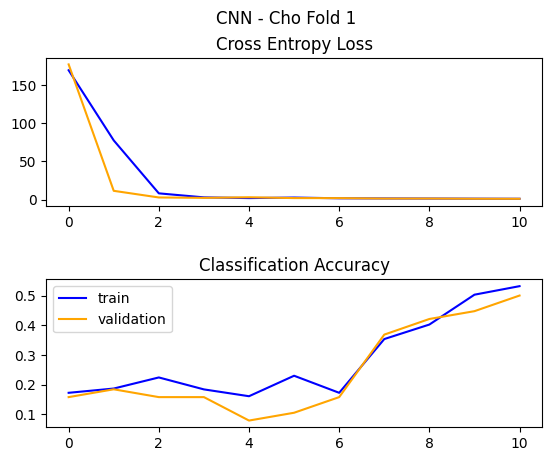

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 8ms/step - loss: 1.0731 - accuracy: 0.5000
Loss:  1.0731102228164673
Accuracy: 50.00%
Fold 1 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_93 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_94 (Conv2D)          (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

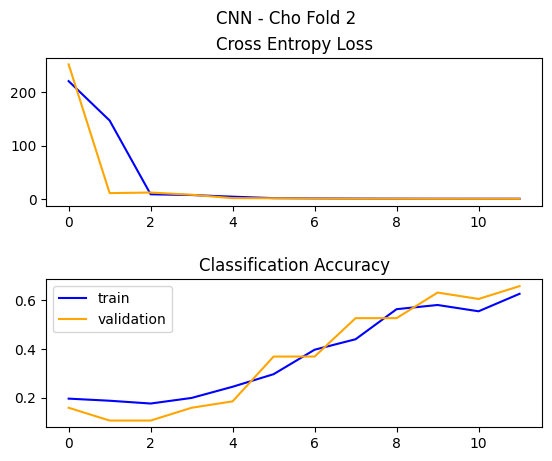

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 11ms/step - loss: 0.8542 - accuracy: 0.6579
Loss:  0.854195773601532
Accuracy: 65.79%
Fold 2 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_96 (Conv2D)          (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

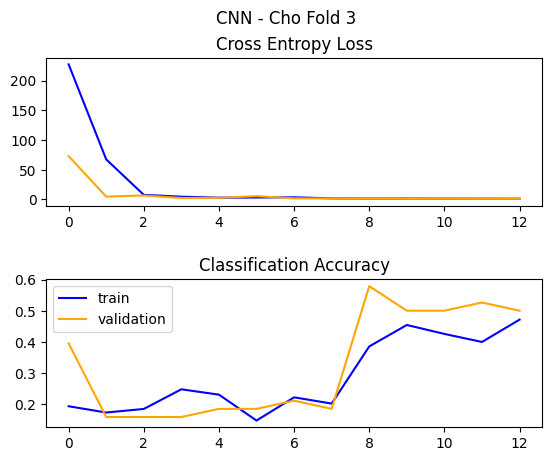

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 6ms/step - loss: 1.0564 - accuracy: 0.5000
Loss:  1.0563801527023315
Accuracy: 50.00%
Fold 3 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_98 (Conv2D)          (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

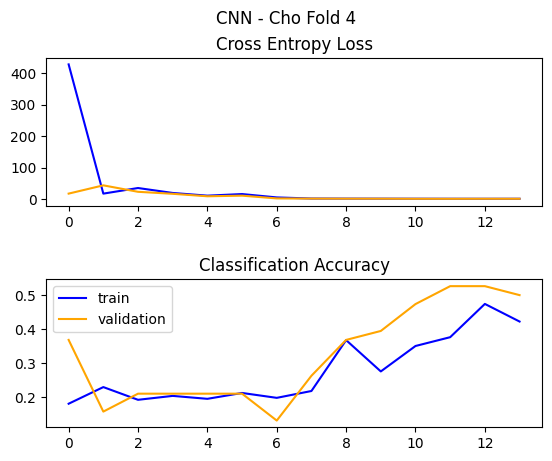

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 6ms/step - loss: 1.2466 - accuracy: 0.5000
Loss:  1.2466435432434082
Accuracy: 50.00%
Fold 4 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_100 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

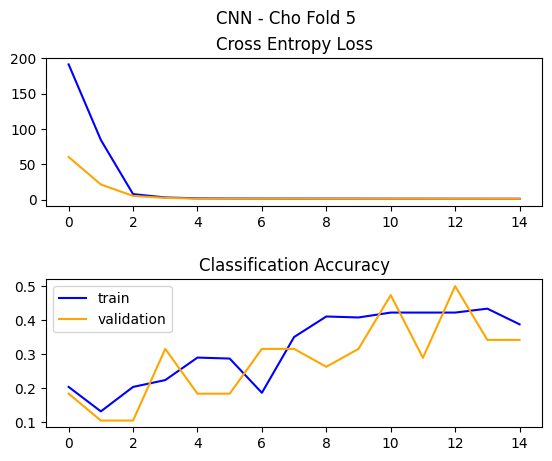

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 7ms/step - loss: 1.1977 - accuracy: 0.3421
Loss:  1.1976704597473145
Accuracy: 34.21%
Fold 5 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_102 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

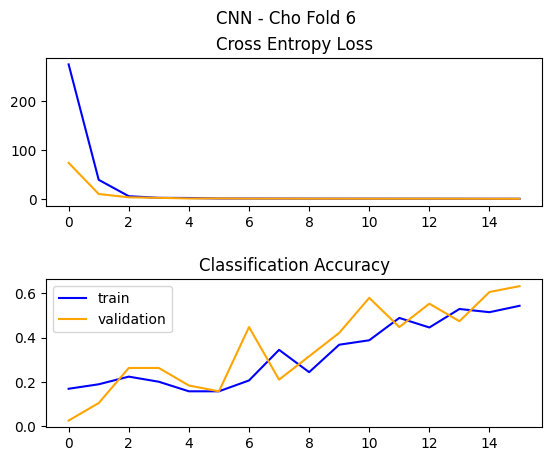

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 5ms/step - loss: 1.0868 - accuracy: 0.6316
Loss:  1.0868136882781982
Accuracy: 63.16%
Fold 6 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_103 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_104 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

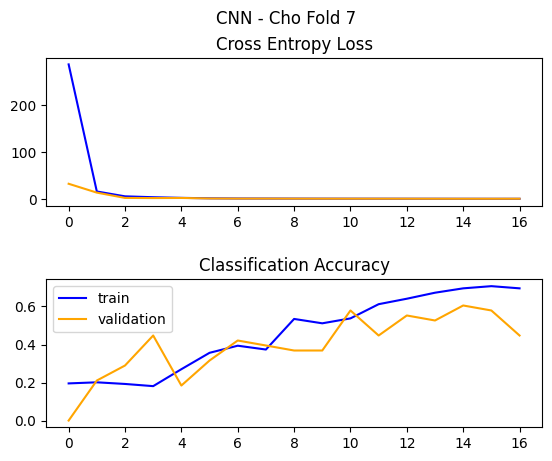

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 8ms/step - loss: 1.0877 - accuracy: 0.4474
Loss:  1.0876595973968506
Accuracy: 44.74%
Fold 7 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_106 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

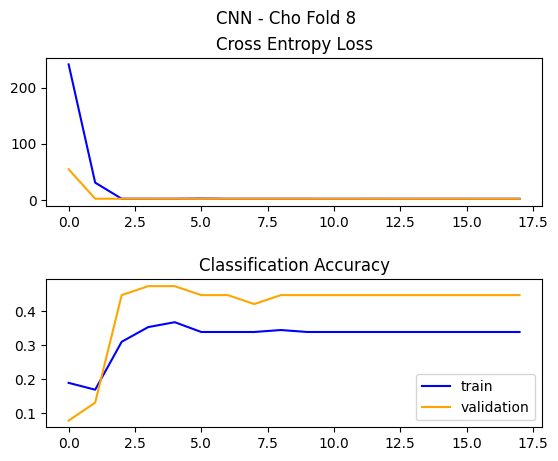

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 4ms/step - loss: 1.6544 - accuracy: 0.4474
Loss:  1.6543610095977783
Accuracy: 44.74%
Fold 8 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_108 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

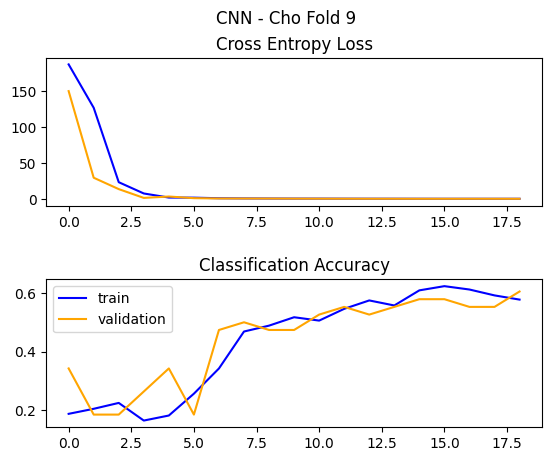

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 5ms/step - loss: 0.9097 - accuracy: 0.6053
Loss:  0.9096972942352295
Accuracy: 60.53%
Fold 9 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_109 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_110 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

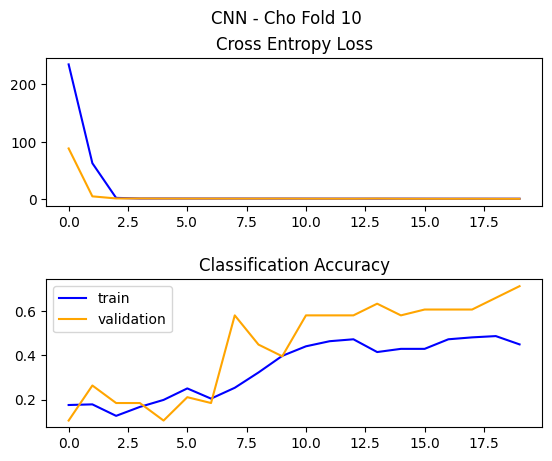

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 5ms/step - loss: 1.0635 - accuracy: 0.7105
Loss:  1.0635151863098145
Accuracy: 71.05%
Fold 10 Complete!
------------------------------------------------------------------


In [501]:
#def run_Cho():
    
# load dataset
df_cho = load_Cho()

print("\nVerifying Data...")

print(df_cho)

print("Data Verified!\n")
print("------------------------------------------------------------------")

# 10 fold cross-validation
model_Cho = {}
for i in range(1,11):
    print("Creating Validation Set...")

    (train_data, train_labels), (val_data, val_labels) = validation_Cho(df_cho)

    print("------------------------------------------------------------------")
    print("Building Model...")

    model_Cho[i-1] = build_model_CNN((3, 6, 1), 6) # 6 labels bcuz 0-5, but 0 is not used!

    print("------------------------------------------------------------------")
    print("Fitting Model...")

    # fit model
    history_Cho = model_Cho[i-1].fit(train_data, train_labels, epochs=10+i, batch_size=64, validation_data=(val_data, val_labels), verbose=0)
    
    # show learning curves
    show_diagnostics(history_Cho, "Cho Fold " + str(i), "validation")

    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # evaluate model
    test_loss, test_acc = model_Cho[i-1].evaluate(val_data,  val_labels)
    print("Loss: ", test_loss)
    print(f"Accuracy: {test_acc :.2%}")
    
    print(f"Fold {i} Complete!")
    print("------------------------------------------------------------------")

#run_Cho()